# Preprocessing

In [147]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
%autoreload 2

In [149]:
import torch

In [150]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
import pandas as pd
from src.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel
from src.utils import *
import matplotlib.pyplot as plt
import os

In [151]:
connection = Connection()
# Get client
client = connection.get_client()

In [164]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [165]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [166]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_timeseries(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W10... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']


218

In [167]:
summarize_null(df_all_wells_preprocessed)

qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
well_code    0
dhp          0
dht          0
whp          0
wht          0
choke        0
dcp          0
well_id      0
wc_mpfm      0
time_idx     0
dtype: int64

In [168]:
df_all_wells_preprocessed["well_code"].unique()

array([0.])

In [169]:
df_train, df_val, df_test = get_random_train_test_split_per_well_with_order_preserved(df=df_all_wells_preprocessed, test_size=0.2)
len(df_train), len(df_val), len(df_test)

(146, 27, 45)

In [170]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.1406


In [171]:
model.score_physics(df_test)

{'W10': {'qo': {'r2': 0.28218083823675844,
   'mae': 20.985273791593144,
   'rmse': 27.91472156644451},
  'qw': {'r2': 0.5319415486015171,
   'mae': 3.6693980751607005,
   'rmse': 6.738591181860246},
  'qg': {'r2': 0.6808891009301747,
   'mae': 1563.1873369283228,
   'rmse': 2072.1437790202667},
  'wgr': {'r2': 0.2563192309687764,
   'mae': 0.0003234937101912803,
   'rmse': 0.0008310488199603013},
  'gor': {'r2': -0.9427320158954582,
   'mae': 13.609529400634457,
   'rmse': 23.588269873050876}}}

In [172]:
model.score_hybrid(df_test)

{'W10': {'qo': {'r2': 0.7584596986131453,
   'mae': 12.088188352946263,
   'rmse': 16.192748797556632},
  'qw': {'r2': 0.5915351666876139,
   'mae': 2.9123700706921727,
   'rmse': 6.295009641415351},
  'qg': {'r2': 0.9167419658849145,
   'mae': 722.1044083056686,
   'rmse': 1058.4300065493455},
  'wgr': {'r2': 0.34702881854396306,
   'mae': 0.00026256298322596444,
   'rmse': 0.0007787180991013615},
  'gor': {'r2': 0.2566521066830937,
   'mae': 10.506642334018284,
   'rmse': 14.59102147664639}}}

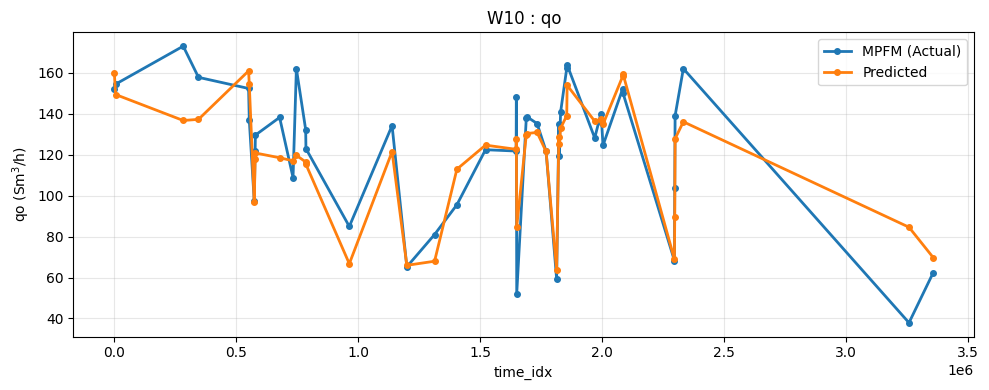

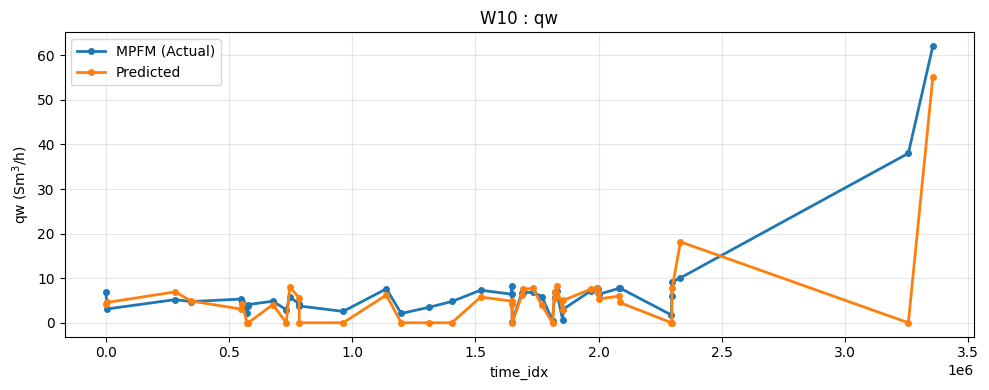

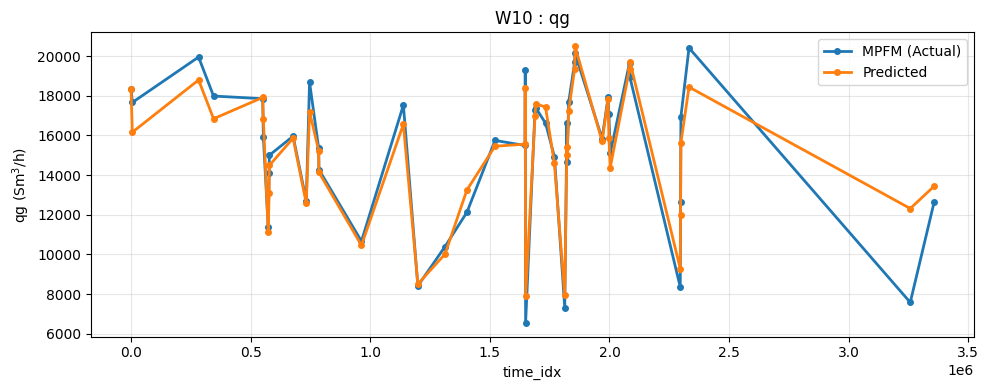

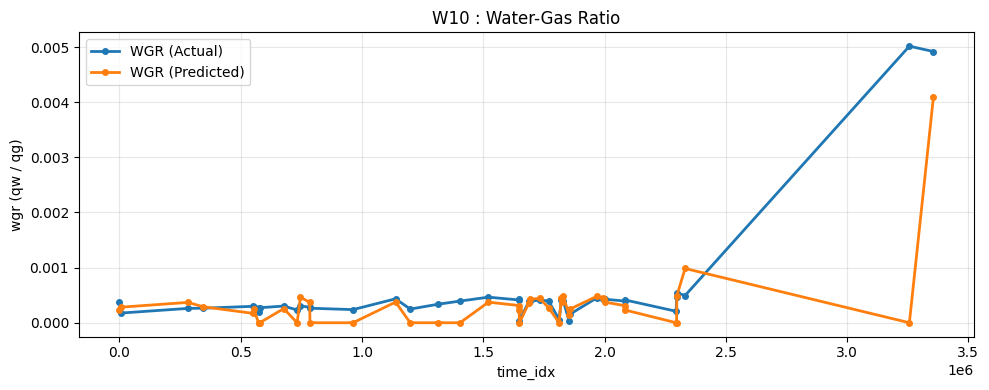

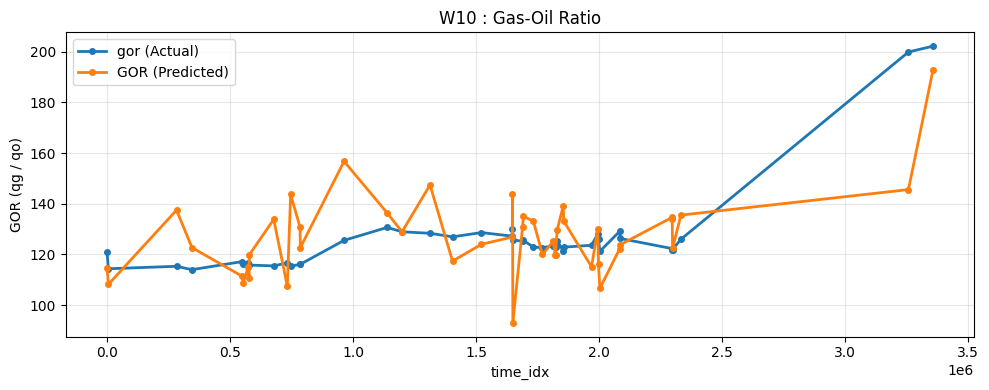

In [176]:
model.plot_predictions(df=df_test, time_col="time_idx", is_hybrid_model=True)

In [177]:
def lowo_with_partial_calibration(
    df,
    n_calibration_points=2,
):
    results = []

    for test_well in df["well_id"].unique():
        df_well = df[df["well_id"] == test_well]
        df_train_other = df[df["well_id"] != test_well]

        df_cal = df_well.iloc[:n_calibration_points]
        df_test = df_well.iloc[n_calibration_points:]

        df_train = pd.concat([df_train_other, df_cal])

        model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
        # model.phys_model.fit_pres = False
        model.fit(df_train)

        results.append({
            "well": test_well,
            "scores": model.hybrid_score(df_test)
        })

    return results


In [178]:
# lowo_with_partial_calibration(df=df_with_targets)